# PS6: Simulation of Ticker Picker Portfolios
In the lecture, we developed the `ticker picker` agent, which learned by analyzing historical daily data sequences the probability that a ticker would outperform an alternative investment over a specified N-trading day period. We considered two scenarios: when the `ticker picker` was unaware of risk and when the agents were risk-aware (where risk, in this context, was measured in powers of $\beta$). 

We had the agents rank their top-10 portfolios, and from that, we computed the probability of a ticker appearing in a top-10 portfolio. We saved all this preference data to avoid rerunning those calculations here.

### Problem
In this problem set, we will use agents trained using `SPY` as the alternative investment to select our portfolio's stocks (or ETFs). This is a different, potentially more exciting set of agents than we constructed in the lecture examples. In particular, we'll query the `SPY` ticker-picker agents and have them vote for a list of tickers to include in our portfolio $\mathcal{P}$ given an investment budget $\mathcal{B}$. We then compare the performance of our portfolio $\mathcal{P}$ (assuming equally weighted) to a portfolio consisting of `SPY` alone.

Walk through the calculations and fill in the missing components.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\asus\Documents\GitHub\PS6-jc3698\Project.toml`
  No Changes to `C:\Users\asus\Documents\GitHub\PS6-jc3698\Manifest.toml`
  Activating project at `c:\Users\asus\Documents\GitHub\PS6-jc3698`
  No Changes to `C:\Users\asus\Documents\GitHub\PS6-jc3698\Project.toml`
  No Changes to `C:\Users\asus\Documents\GitHub\PS6-jc3698\Manifest.toml`
    Updating registry at `C:\Users\asus\.julia\registries\General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `C:\Users\asus\Documents\GitHub\PS6-jc3698\Project.toml`
  No Changes to `C:\Users\asus\Documents\GitHub\PS6-jc3698\Manifest.toml`


## Prerequisites: Load ticker-picker save file and out-of-sample market data
Let's begin by loading the [HDF5 encoded risk-blind saved file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) generated in the alternative investment advanced example using [a `load(...)`  method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl). First, we specify the path to the saved file in the `path_to_save_file::String` variable:

In [2]:
path_to_save_file = joinpath(_PATH_TO_DATA, "TickerPickerAgent-Simulation-State-ALT-RA-SPY-N-10000.jld2");

then [call the `load(...)` method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl), which reads the binary saved file and returns the saved data as a dictionary; we assign the data to the `saved_state_dict::Dict{String, Any}` variable:

In [3]:
saved_state_dict = load(path_to_save_file);

### Set constant values
In the code block below, we set various constant values (and compute some derived constants) that we use in the tasks below. We generally access these values from the `saved_state_dict::Dict{String, Any}` by passing a `key::String` value to the saved data dictionary. Please see the comment beside the code line for more details about the value and what we'll use it for.

In [4]:
insampledataset = saved_state_dict["insampledata"]; # OHLC data 460 or so firms/ETFs
my_tickers = saved_state_dict["tickers"] |> sort; # *sorted* list of tickers we specified in the worked example
preferences_risk_blind = saved_state_dict["preferences_risk_blind"]; # prefs in the risk-blind case
preferences_risk_aware = saved_state_dict["preferences_risk_aware"]; # prefs in the risk-blind case
Δt = (1.0/252); # assume 252-days per trading year
K = length(my_tickers); # how tickers (arms) do we have? 
number_of_agents = 10000; # how many agents do we want
total_budget_to_allocation = 100.0; # Assume we have 100 USD to allocate

### Out-of-sample price data
Next, we'll load out-of-sample daily price data to test the ticker-picker preferences.
We gathered daily open-high-low-close data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `10-25-2024`, along with data for a few exchange-traded funds and volatility products during that time. We'll use this data in the subsequent tasks below, but we must load and clean it up first. 
* First, we'll load the data and remove tickers that do not have the maximum number of trading days. We'll store the cleaned data in the `dataset::Dict{String, DataFrame}` variable.
* Next, we'll get a list of all the tickers in the `dataset,` sort them alphabetically, and store them in the `all_tickers_array` variable.

In [5]:
original_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"];

#### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [6]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Second, let's iterate through our data and collect only those tickers with `maximum_number_trading_days::Int64` records. Save that data in the `outofsampledataset::Dict{String,DataFrame}` variable:

In [7]:
outofsampledataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        outofsampledataset[ticker] = data;
    end
end
outofsampledataset;

We compare the ticker-picker portfolio performance against `SPY,` so let's get the index of `SPY` and store this value in the `index_SPY::Int64` variable:

In [8]:
list_of_all_tickers = keys(outofsampledataset) |> collect |> sort;
index_SPY = findfirst(x-> x== "SPY", list_of_all_tickers);
price_series_SPY = outofsampledataset["SPY"];

## Task 1: Generate a random ticker-picker portfolio
In this task, you will sample the agents and have them vote on what to include in your portfolio based on their analysis of the past data. The first thing we need to do is to select which preference dataset we want to sample, either the risk-blind or the risk-adjusted dataset. Let's specify this in the `preference_dataset` variable:

In [9]:
preference_dataset, risktag = let
    
    preference_dataset = nothing;
    risktag = "risk_blind"; # Choose {risk_aware | risk_blind} # make a choice! (Type: string)
    
    if (risktag == "risk_aware")
        preference_dataset = preferences_risk_aware
    else
        preference_dataset = preferences_risk_blind
    end

    preference_dataset, risktag
end;

In [10]:
println("We have chosen: $(risktag)")

We have chosen: risk_blind


Next, now that we have selected our preference dataset, i.e., our understanding of the past world, we sample that dataset using [a nested `for-loop`](https://docs.julialang.org/en/v1/base/base/#for) where we iterate over _all K_ tickers in the outer-loop and _all agents_ in the inner loop. Once we select a ticker (index `i`) and an agent (index `j`), we:
* We access the agent's belief about a ticker encoded as a [`Beta` distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Beta). From that, we extract the ($\alpha$,$\beta$) parameters, i.e., the number of times a ticker beat the alternative investment versus the number of times the agent lost versus the alternative investment, respectively.
* We then compute the agent's vote for the ticker by first computing the expected value for the ticker to beat the alternative investment. We then use this value to construct [a `Bernoulli` distribution](https://juliastats.org/Distributions.jl/latest/univariate/#Distributions.Bernoulli) and sample that distribution. It returns a value of `1` if the agent wants to include the ticker or `0` otherwise.
* Finally, we store the agent's vote (column) for the ticker (row) in the `votes::Array{Int64,2}` array. Each row corresponds to a ticker, while each column is the vote of an agent to include `1` or exclude `0` from the ticker.

In [11]:
votes = let
    votes = Array{Int64,2}(undef, K, number_of_agents);
    for i = 1:K
        for j = 1:number_of_agents
            α, β = preference_dataset[i,j] |> d -> params(d);
            votes[i,j] = α/(α + β) |> θ -> Bernoulli(θ) |> d -> rand(d) |> vote -> trunc(Int64,vote);
        end
    end
    votes
end

29×10000 Matrix{Int64}:
 0  1  0  1  1  0  0  0  0  0  0  0  0  …  0  1  1  0  0  0  1  1  1  0  0  0
 0  0  0  0  1  0  1  0  1  1  1  0  1     1  0  1  0  1  1  0  0  1  0  1  1
 0  0  1  0  1  1  1  0  1  0  0  1  1     0  0  0  0  0  1  1  1  0  0  0  0
 0  0  0  0  0  1  0  0  0  1  1  1  0     0  1  1  1  0  1  1  1  0  0  1  0
 0  1  0  1  1  0  1  1  0  0  0  1  0     0  1  0  1  1  0  1  1  1  1  1  0
 0  0  1  1  0  1  0  1  0  1  0  0  1  …  1  0  1  1  0  1  1  0  1  1  0  0
 0  0  1  1  0  1  1  1  0  0  1  1  0     0  1  1  0  0  1  0  1  0  0  1  1
 0  0  1  0  1  0  1  1  1  1  0  1  1     1  0  1  0  1  1  0  0  1  0  1  1
 1  0  0  0  0  0  1  0  0  1  1  1  0     1  0  0  0  0  0  1  0  0  1  0  1
 1  1  1  1  1  1  1  1  1  0  0  1  0     1  1  0  0  1  0  0  0  0  0  1  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 1  0  0  0  1  0  0  1  1  0  0  1  1  …  1  0  1  1  1  0  0  0  1  0  0  0
 0  0  1  0  1  1  0  0  0  0  0  0  1   

Now that all the agents have voted, let's count the votes and see which tickers will be included in our portfolio. To get a better idea of the agent voting, let's build a table [using the `pretty_table(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl), which displays the ticker and the percentage vote tally.

#### Summary
`Unide` the code block below to see how we computed the ticker score and displayed it in a [table using the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl).
* The list of scores shows the fraction of the `number_of_agents::Int64` that voted to include a particular ticker symbol in the portfolio. Different scores are observed depending on whether you use the risk-aware or risk-blind preference data.

In [12]:
let
    df = DataFrame()
    for i = 1:K
        score = sum(votes[i,:]) |> raw_score -> raw_score/number_of_agents;
        row_data = (
            ticker = my_tickers[i],
            score = score
        );
        push!(df, row_data);
    end
    pretty_table(df)
end

┌────────┬─────────┐
│ ticker │   score │
│ String │ Float64 │
├────────┼─────────┤
│   AAPL │  0.4806 │
│    AMD │  0.5024 │
│    BAC │  0.4839 │
│      C │  0.4339 │
│  CMCSA │  0.4174 │
│    ECL │  0.4637 │
│     GS │  0.4242 │
│   INTC │  0.5036 │
│    JNJ │  0.4156 │
│    JPM │  0.4765 │
│     KR │   0.458 │
│    LMT │   0.449 │
│    MET │  0.4504 │
│    MMM │  0.4143 │
│    MRK │  0.4526 │
│   MSFT │  0.5634 │
│     MU │  0.4518 │
│   NFLX │  0.5563 │
│    NOC │  0.4432 │
│   NVDA │  0.4781 │
│    OXY │  0.4478 │
│    PEP │  0.4163 │
│    QQQ │  0.5266 │
│    SPY │   0.998 │
│   SPYD │  0.4219 │
│    SRE │  0.4438 │
│   TSLA │  0.4568 │
│    UNH │   0.476 │
│    WFC │  0.4328 │
└────────┴─────────┘


In [13]:
do_I_see_the_overall_score_table = true; # {true | false}

### Select your portfolio tickers
Given the scores above, we need a decision rule to pick which ticker to include in the portfolio $\mathcal{P}$. For example, is a simple majority required to accept a ticker? Let's specify a value the `cutoff::Float64` variable.
* __How do I pick this__? The cutoff controls how deep into the rankings we are willing to go. A large value of the cutoff variable will select only those tickers that many agents have ranked in their top-M lists. On the other hand, smaller values of the cutoff variable will select tickers that only a subset of agents selected.

In [14]:
cutoff = 0.40; # Assume a score of x%, e.g., 50% or 0.50 is required to be in your portfolio (adjust to what you want). Must be (0,1] 

We accept the ticker if the score (percentage of the vote) exceeds the `cutoff::Float64` value specified above. If not, we reject the ticker. Let's populate the `portfolio_tickers::Array{Int64,1}` array with values of `1` and `0` indicating whether to include or reject a ticker, respectively, by iterating over the tickers using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for)
* First, we compute a `score::Float64` value, the fraction of agents that voted to include the ticker in the portfolio. We then apply the decision rule and set a value for the `keep_flag::Int64` variable. Finally, we store that value in the `portfolio_tickers::Array{Int64,1}` array.

In [15]:
portfolio_tickers = Array{Int64,1}(undef, K);
for i = 1:K
    score = sum(votes[i,:]) |> raw_score -> raw_score/number_of_agents;
    keep_flag = 0; # default value, we reject this ticker
    if (score ≥ cutoff)
        keep_flag = 1;
    end
    portfolio_tickers[i] = keep_flag
end
number_of_tickers_we_keep = findall(x-> x == 1, portfolio_tickers) |> length;

To make our life easier below, let's build a `portfolio_ticker_index_lookup` table that maps the `ticker::String` symbol to the index of that ticker in our portfolio:

In [16]:
portfolio_ticker_index_lookup = Dict{String, Int64}();
idx = findall(x-> x == 1, portfolio_tickers)
for i ∈ eachindex(idx) 
    ticker = my_tickers[idx[i]];
    portfolio_ticker_index_lookup[ticker] = i;
end
portfolio_ticker_index_lookup

Dict{String, Int64} with 29 entries:
  "JPM"  => 10
  "MSFT" => 16
  "C"    => 4
  "MRK"  => 15
  "UNH"  => 28
  "SPY"  => 24
  "BAC"  => 3
  "MU"   => 17
  "SRE"  => 26
  "TSLA" => 27
  "KR"   => 11
  "AMD"  => 2
  "INTC" => 8
  "NVDA" => 20
  "MMM"  => 14
  "NOC"  => 19
  "ECL"  => 6
  "LMT"  => 12
  "GS"   => 7
  ⋮      => ⋮

Now that we have the `portfolio_tickers::Array{Int64,1}`, we can build a table to see what's included in our portfolio. A value of `1` in the `portfolio_tickers::Array{Int64,1}` array indicates we keep the ticker, `0` indicates we reject the ticker. 
* `Unhide` the code block below to see how we built a ticker inclusion table [using the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [17]:
let
    df = DataFrame();
    counter = 1;
    for i = 1:K
        keep_flag = portfolio_tickers[i];
        if (keep_flag == 1)
            ticker = my_tickers[i];
            row_data = (
                index = counter,
                ticker = ticker,
            );
            push!(df, row_data);
            counter += 1;
        end
    end
    pretty_table(df)
end

┌───────┬────────┐
│ index │ ticker │
│ Int64 │ String │
├───────┼────────┤
│     1 │   AAPL │
│     2 │    AMD │
│     3 │    BAC │
│     4 │      C │
│     5 │  CMCSA │
│     6 │    ECL │
│     7 │     GS │
│     8 │   INTC │
│     9 │    JNJ │
│    10 │    JPM │
│    11 │     KR │
│    12 │    LMT │
│    13 │    MET │
│    14 │    MMM │
│    15 │    MRK │
│    16 │   MSFT │
│    17 │     MU │
│    18 │   NFLX │
│    19 │    NOC │
│    20 │   NVDA │
│    21 │    OXY │
│    22 │    PEP │
│    23 │    QQQ │
│    24 │    SPY │
│    25 │   SPYD │
│    26 │    SRE │
│    27 │   TSLA │
│    28 │    UNH │
│    29 │    WFC │
└───────┴────────┘


In [18]:
do_I_see_my_ticker_table = true; # select {true | false}

## Task 2: Simulate out-of-sample portfolio performance 
In this task, we simulate how well our portfolio will perform. Now that we have asked the agents which tickers to include in our portfolio $\mathcal{P}$, let's run some simulations to see how this portfolio performs using an out-sample-data price set not used in agent training assuming equal portfolio weighting factors. As an alternative investment, we'll compare our portfolio against the performance of $\mathcal{B}$ invested in `SPY.`

Let's begin by generating an equally weighted allocation, which we store in the `ω::Array{Float64,1}` array

In [19]:
ω = (1/number_of_tickers_we_keep)*ones(number_of_tickers_we_keep);

Next, convert the fractions $\omega_{i}$ into share counts $n_{i}$ at the beginning of the out-of-sample period. We know, from a `USD` balance, that:
$$
\begin{equation}
n_{i} = \frac{\omega_{i}\cdot{\mathcal{B}}}{S_{i,\circ}}
\end{equation}
$$
where $n_{i}$ denote the number of shares to purchase in period 1, $\omega_{i}$ denotes the fraction of the budget $\mathcal{B}$ used for ticker $i$ in the portfolio, assuming a `USD` basis, and $S_{i,\circ}$ denotes the share price of ticker $i$ when initializing the portfolio. We assume that we allocate the budget $\mathcal{B}$ at the beginning of the out-of-sample period and do not reallocate the portfolio weights. 
* We store the investment budget in the `total_budget_to_allocation::Float64` variable and the number of shares of each ticker in the `n::Array{Float64,1}` array. We compute the number of shares using the expression above, where we iterate over _all K_ possible tickers and check if the ticker is in our portfolio $\mathcal{P}$. If yes, we compute the share count using [the volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for period `1` and the random allocation fraction $\omega_{i}$.
* The `counter::Int64` value keeps track of the index of the ticker in the portfolio, i.e., the order of tickers in the portfolio (not the original list of tickers).

In [20]:
n = let
    n = Array{Float64,1}(undef, number_of_tickers_we_keep);
    counter = 1;
    for i = 1:K
        if (portfolio_tickers[i] == 1)
            ticker = my_tickers[i];
            price_df = outofsampledataset[ticker];
            n[counter] = (total_budget_to_allocation*ω[counter])/(price_df[1,:volume_weighted_average_price]);
            
            # update -
            counter+=1;
        end
    end
    n
end;

### Simulate out-of-sample portfolio performance
To compute the out-of-sample wealth, we first populate the `portfolio_vwap_array::Array{Float64,2}` array, which holds [the volume weighted average price (vwap)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) prices for the tickers in portfolio $\mathcal{P}$. 
* We first initialize the `portfolio_vwap_array::Array{Float64,2}` array, then get the prices for the out-of-sample dataset by iterating over _all K_ tickers, checking if ticker `i` is in our portfolio; if yes, we get the `ticker::String` symbol, lookup the price data in the `outofsampledataset::Dict{String, DataFrame}` dictionary
* We then extract the [the volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for period `1:(maximum_number_trading_days)`, i.e., each trading period value that we have for each ticker in the `outofsampledataset::Dict{String, DataFrame}` dictionary and insert into the `portfolio_vwap_array` array.
* The `counter::Int64` value keeps track of the index of the ticker in the portfolio, i.e., the order of tickers in the portfolio (not the original list of tickers).

In [21]:
portfolio_vwap_array = let
    portfolio_vwap_array = Array{Float64,2}(undef, maximum_number_trading_days, number_of_tickers_we_keep);
    counter = 1;
    for i ∈ 1:K
        if (portfolio_tickers[i] == 1)
            ticker = my_tickers[i];
            price_df = outofsampledataset[ticker];
            for j = 1:(maximum_number_trading_days)
                portfolio_vwap_array[j, counter] = price_df[j, :volume_weighted_average_price];
            end
    
            # update -
            counter += 1;
        end
    end
    portfolio_vwap_array
end;

Finally, we can compute the performance of our portfolio and store this in the `wealth_array::Array{Float64,2}` variable. To do this, we iterate through each trading period in the out-of-sample dataset [using a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where for each period, we:
* Compute the scalar product between the share count vector $n$ and [the vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price) at time `t` using [the `dot(...)` function exported by the built-in Julia LinearAlgebra package.](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.dot) Next, we compute the wealth associated with the `SPY` only portfolio, where we assume that the entire `total_budget_to_allocation` budget is invested in `SPY,` i.e., $\omega = 1$.
* Finally, we store portfolio wealth, and the `SPY` only wealth in the `wealth_array::Array{Float64,2}`, where each row is a time-point, column `1` is our portfolio, and column `2` is `SPY.`

In [22]:
wealth_array = let
    wealth_array = Array{Float64,2}(undef, maximum_number_trading_days, 2)
    for t = 1:maximum_number_trading_days
        wealth_value_P = dot(n,portfolio_vwap_array[t,:]) # our portfolio
        wealth_value_SPY = (total_budget_to_allocation/price_series_SPY[1,:volume_weighted_average_price])*price_series_SPY[t,:volume_weighted_average_price] # spy on its own
        wealth_array[t,1] = wealth_value_P
        wealth_array[t,2] = wealth_value_SPY
    end
    wealth_array
end;

### Visualize
`Unhide` the code block below to see how we plotted the wealth of our portfolio (blue line) and the `SPY` investment (red line) for the out-of-sample dataset. 
#### Summary
* Switching the `preference_dataset` variable may lead to different performance of the portfolio $\mathcal{P}$ relative to `SPY` alone. We expect that while the wealth generated by the risk-aware portfolio is similar to or lower than the risk-blind selection, the performance variance will also be less. Thus, a risk-sensitive agent is willing to trade return for less uncertainty.
* __Fun idea__: Our portfolio allocation is equally weighted. A better comparison would be to compute optimal weights $\omega_{i}$ values by solving the minimum variance allocation problem we explored earlier (we leave this to you). Curious to see what happens.
* __Another fun idea__: We developed the ticker pickers for a limited set of assets. I'm curious to see what happens if we expand the asset set beyond the 30 or so we picked, and re-run this analysis. 

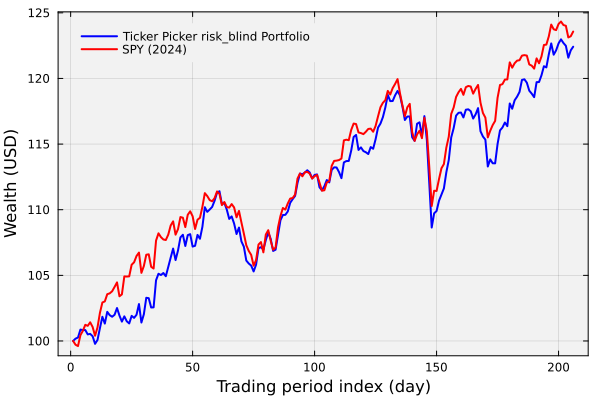

In [23]:
let
    plot(wealth_array[:,1], c=:blue, label="Ticker Picker $(risktag) Portfolio", lw=2, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(wealth_array[:,2], c=:red, label="SPY (2024)", lw=2)
    xlabel!("Trading period index (day)", fontsize = 18)
    ylabel!("Wealth (USD)", fontsize=18)
end

In [24]:
do_I_see_the_OOS_wealth_plot = true; # {true | false}

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [25]:
let 
    @testset verbose = true "CHEME 5660 problem set 6 test suite" begin

        @testset "Task 1: Preferences" begin
            @test risktag == "risk_aware" || risktag == "risk_blind"
            @test isempty(preference_dataset) == false
            @test isempty(votes) == false
            @test do_I_see_the_overall_score_table == true
            @test 0 < cutoff && cutoff ≤ 1.0
            @test do_I_see_my_ticker_table == true
        end

        @testset "Task 2: Simulation" begin
            @test isempty(ω) == false
            @test isempty(portfolio_vwap_array) == false
            @test isempty(wealth_array) == false
            @test do_I_see_the_OOS_wealth_plot == true
        end
    end
end;

Test Summary:                       | Pass  Total  Time
CHEME 5660 problem set 6 test suite |   10     10  0.5s
  Task 1: Preferences               |    6      6  0.5s
  Task 2: Simulation                |    4      4  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.